In [80]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import utils, datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [81]:
torch.manual_seed(0)

In [82]:
dataroot = "data/mnist"

workers = 10

batch_size = 100

image_size = 32

nc = 1

num_classes = 10

nz = 100

ngf = 64

ndf = 64

num_epochs = 10

lr = 0.0002

beta1 = 0.5

In [83]:
train_data = datasets.MNIST(
    root=dataroot,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    download=True
)
test_data = datasets.MNIST(
    root=dataroot,
    train=False,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
dataset = train_data+test_data
print(f'Total Size of Dataset: {len(dataset)}')

Total Size of Dataset: 70000


In [84]:
dataloader = DataLoader (
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

In [85]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and 1 > 0) else 'cpu')

In [86]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

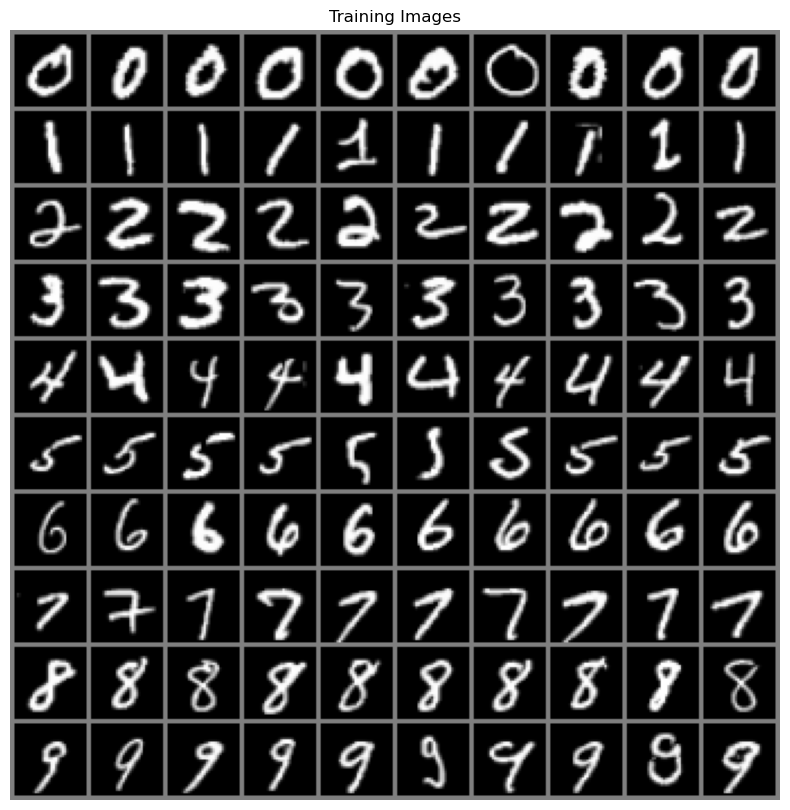

In [87]:
imgs = {}
for x, y in dataset:
    if y not in imgs:
        imgs[y] = []
    elif len(imgs[y])!=10:
        imgs[y].append(x)
    elif sum(len(imgs[key]) for key in imgs)==100:
        break
    else:
        continue
        
imgs = sorted(imgs.items(), key=lambda x:x[0])
imgs = [torch.stack(item[1], dim=0) for item in imgs]
imgs = torch.cat(imgs, dim=0)

plt.figure(figsize=(10,10))
plt.title("Training Images")
plt.axis('off')
imgs = utils.make_grid(imgs, nrow=10)
plt.imshow(imgs.permute(1, 2, 0)*0.5+0.5)

In [88]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.image = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )
        self.label = nn.Sequential(
            nn.ConvTranspose2d(num_classes, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)

In [89]:
netG = Generator(1).to(device)

netG.apply(weights_init)

Generator(
  (image): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (label): Sequential(
    (0): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [90]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.image = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.label = nn.Sequential(
            nn.Conv2d(num_classes, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.main = nn.Sequential(
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)

In [91]:
netD = Discriminator(1).to(device)

netD.apply(weights_init)

Discriminator(
  (image): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (label): Sequential(
    (0): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (main): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [92]:
criterion = nn.BCEWithLogitsLoss()

real_label_num = 1.
fake_label_num = 0.

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

label_1hots = torch.zeros(10,10)
for i in range(10):
    label_1hots[i,i] = 1
label_1hots = label_1hots.view(10,10,1,1).to(device)

label_fills = torch.zeros(10, 10, image_size, image_size)
ones = torch.ones(image_size, image_size)
for i in range(10):
    label_fills[i][i] = ones
label_fills = label_fills.to(device)

fixed_noise = torch.randn(100, nz, 1, 1).to(device)
fixed_label = label_1hots[torch.arange(10).repeat(10).sort().values]

In [93]:
img_list = []
G_losses = []
D_losses = []
D_x_list = []
D_z_list = []
loss_tep = 10

print("Starting Training Loop...")
for epoch in range(num_epochs):

    beg_time = time.time()
    for i, data in enumerate(dataloader):
        netD.zero_grad()
        
        real_image = data[0].to(device)
        b_size = real_image.size(0)

        real_label = torch.full((b_size,), real_label_num).to(device)
        fake_label = torch.full((b_size,), fake_label_num).to(device)
        
        G_label = label_1hots[data[1]]
        D_label = label_fills[data[1]]
        
        noise = torch.randn(b_size, nz, 1, 1).to(device)

        with torch.cuda.amp.autocast():
            fake = netG(noise, G_label)

        with torch.cuda.amp.autocast():
            output_real = netD(real_image, D_label).view(-1)
            errD_real = criterion(output_real, real_label)

            output_fake = netD(fake.detach(), D_label).view(-1)
            errD_fake = criterion(output_fake, fake_label)

        errD_real.backward()
        D_x = output_real.mean().item()

        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()

        with torch.cuda.amp.autocast():        
            output = netD(fake, D_label).view(-1)
            errG = criterion(output, real_label)


        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        end_time = time.time()
        run_time = round(end_time-beg_time)
        print(
            f'Epoch: [{epoch+1:0>{len(str(num_epochs))}}/{num_epochs}]',
            f'Step: [{i+1:0>{len(str(len(dataloader)))}}/{len(dataloader)}]',
            f'Loss-D: {errD.item():.4f}',
            f'Loss-G: {errG.item():.4f}',
            f'D(x): {D_x:.4f}',
            f'D(G(z)): [{D_G_z1:.4f}/{D_G_z2:.4f}]',
            f'Time: {run_time}s',
            end='\r'
        )

        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        D_x_list.append(D_x)
        D_z_list.append(D_G_z2)
        
        if errG < loss_tep:
            torch.save(netG.state_dict(), 'model.pt')
            loss_tep = errG

    with torch.no_grad():
        fake = netG(fixed_noise, fixed_label).detach().cpu()
    img_list.append(utils.make_grid(fake, nrow=10))
    
    print()

Starting Training Loop...
Epoch: [01/10] Step: [700/700] Loss-D: 0.7314 Loss-G: 2.1964 D(x): 1.1768 D(G(z)): [-2.1270/-2.0293] Time: 5ss
Epoch: [02/10] Step: [700/700] Loss-D: 1.0599 Loss-G: 2.3302 D(x): 1.1660 D(G(z)): [-0.3672/-2.1855] Time: 4ss
Epoch: [03/10] Step: [700/700] Loss-D: 0.7801 Loss-G: 2.4270 D(x): 1.7344 D(G(z)): [-0.5322/-2.2930] Time: 4ss
Epoch: [04/10] Step: [700/700] Loss-D: 1.0700 Loss-G: 3.0031 D(x): 2.3965 D(G(z)): [0.2034/-2.9316] Time: 5s5s
Epoch: [05/10] Step: [700/700] Loss-D: 1.1673 Loss-G: 0.9414 D(x): -0.5337 D(G(z)): [-3.9199/-0.1033] Time: 5s
Epoch: [06/10] Step: [700/700] Loss-D: 0.3581 Loss-G: 2.9809 D(x): 2.9297 D(G(z)): [-1.6240/-2.9062] Time: 5ss
Epoch: [07/10] Step: [700/700] Loss-D: 0.2062 Loss-G: 2.9957 D(x): 2.4277 D(G(z)): [-3.4043/-2.9160] Time: 5ss
Epoch: [08/10] Step: [700/700] Loss-D: 0.1139 Loss-G: 3.4480 D(x): 3.5352 D(G(z)): [-3.2461/-3.4043] Time: 5sss
Epoch: [09/10] Step: [700/700] Loss-D: 1.2199 Loss-G: 4.7461 D(x): 4.8398 D(G(z)): [0

59.5 - Loss-D: 0.0828 Loss-G: 3.8640

1 11.9 - Loss-D: 0.0760 Loss-G: 3.9650          complile dont help (i can even see the difference in pics) much worse

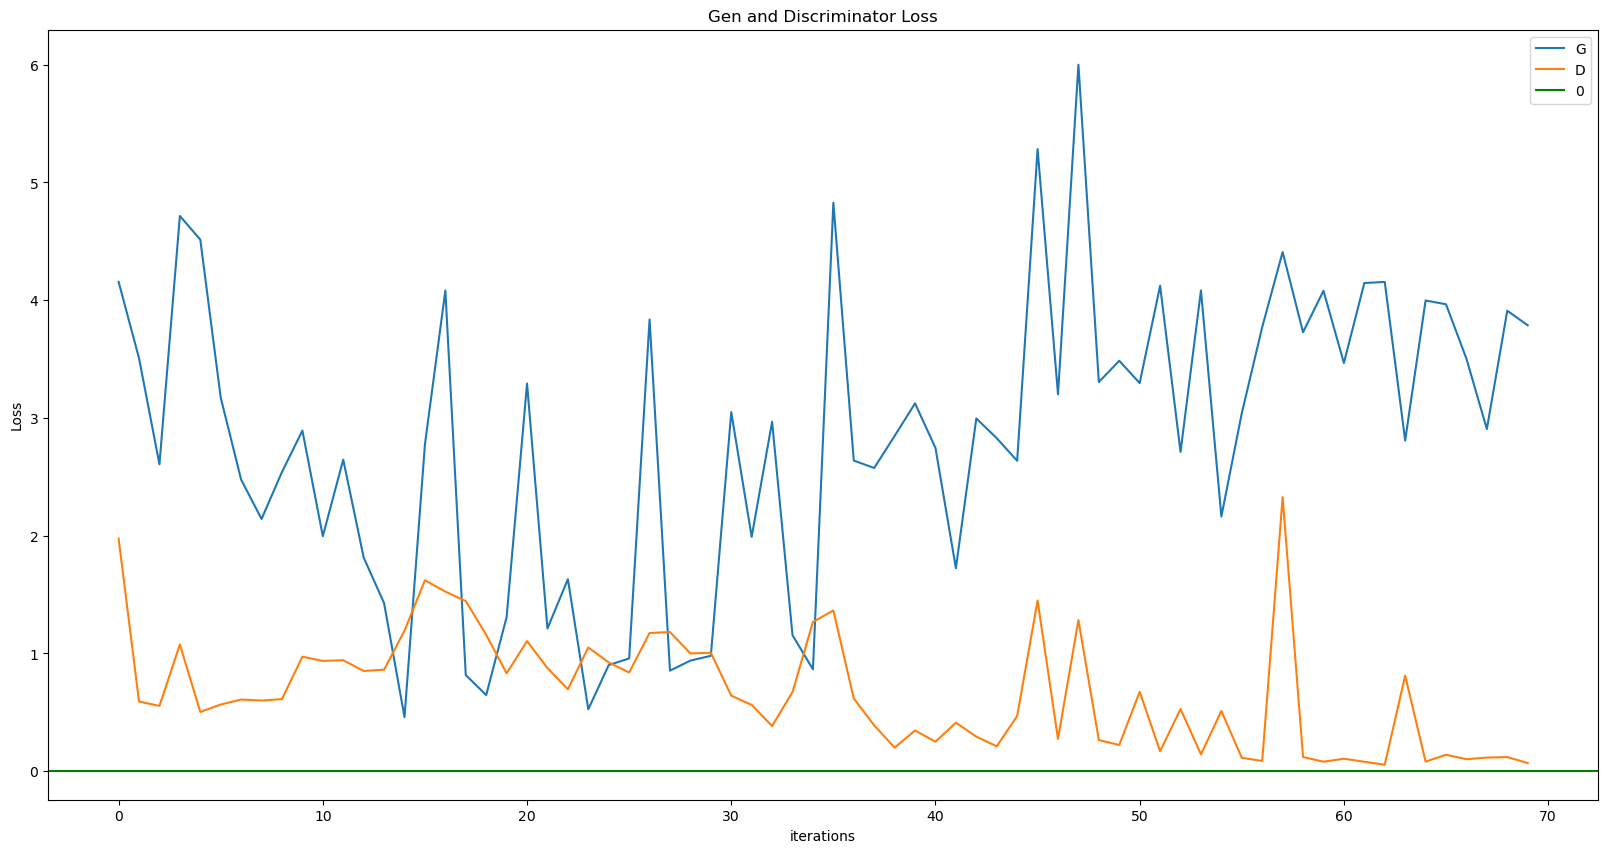

In [94]:
plt.figure(figsize=(20, 10))
plt.title("Gen and Discriminator Loss")
plt.plot(G_losses[::100], label="G")
plt.plot(D_losses[::100], label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.axhline(y=0, label="0", c='g')
plt.legend()

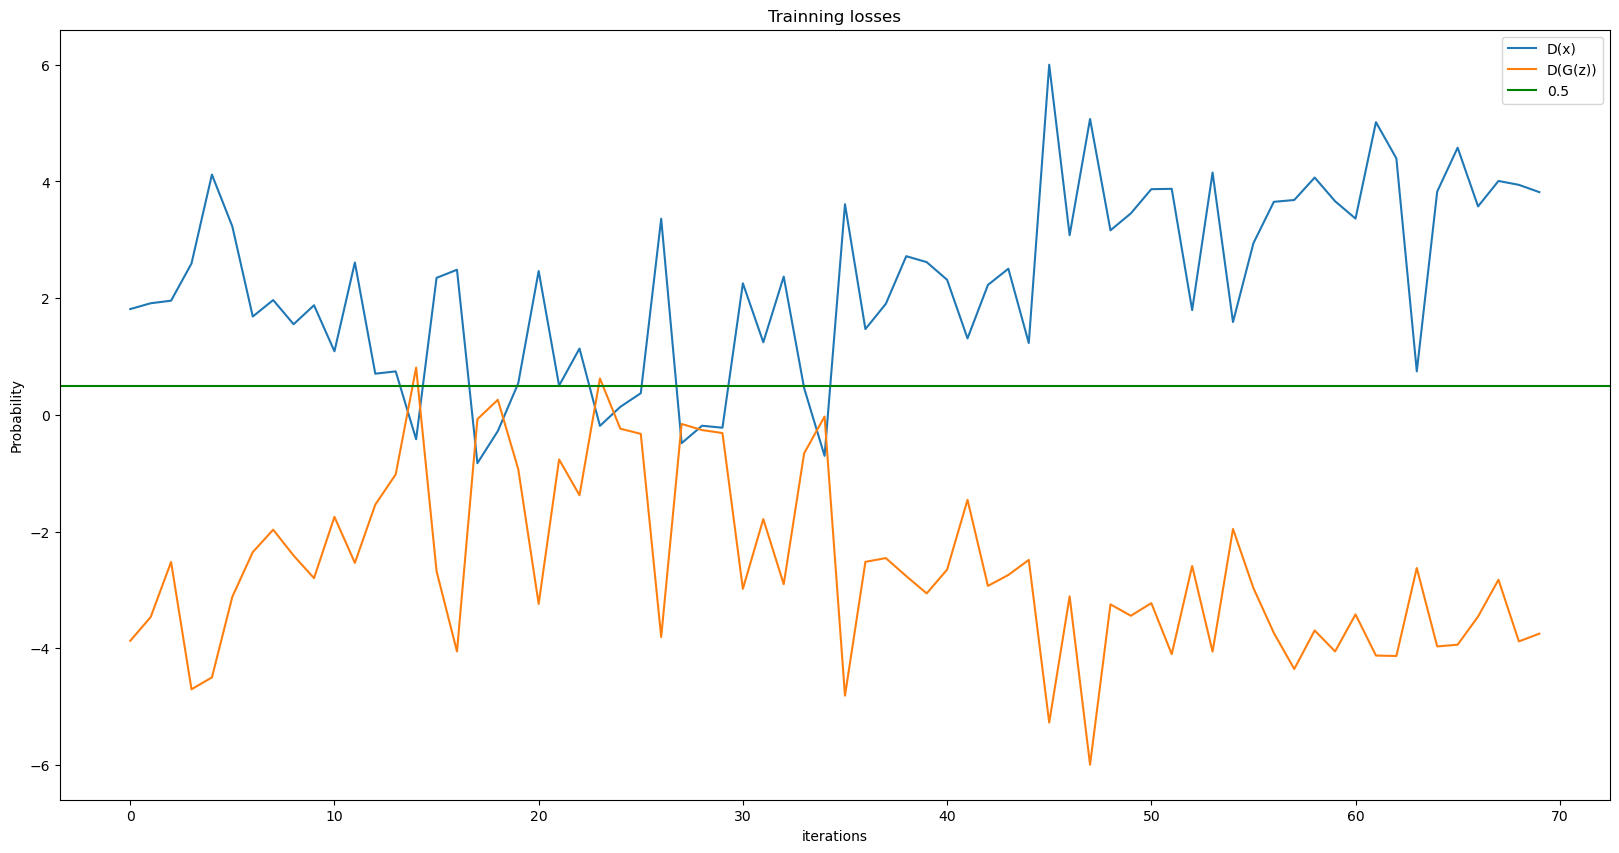

In [95]:
plt.figure(figsize=(20, 10))
plt.title("Trainning losses")
plt.plot(D_x_list[::100], label="D(x)")
plt.plot(D_z_list[::100], label="D(G(z))")
plt.xlabel("iterations")
plt.ylabel("Probability")
plt.axhline(y=0.5, label="0.5", c='g')
plt.legend()

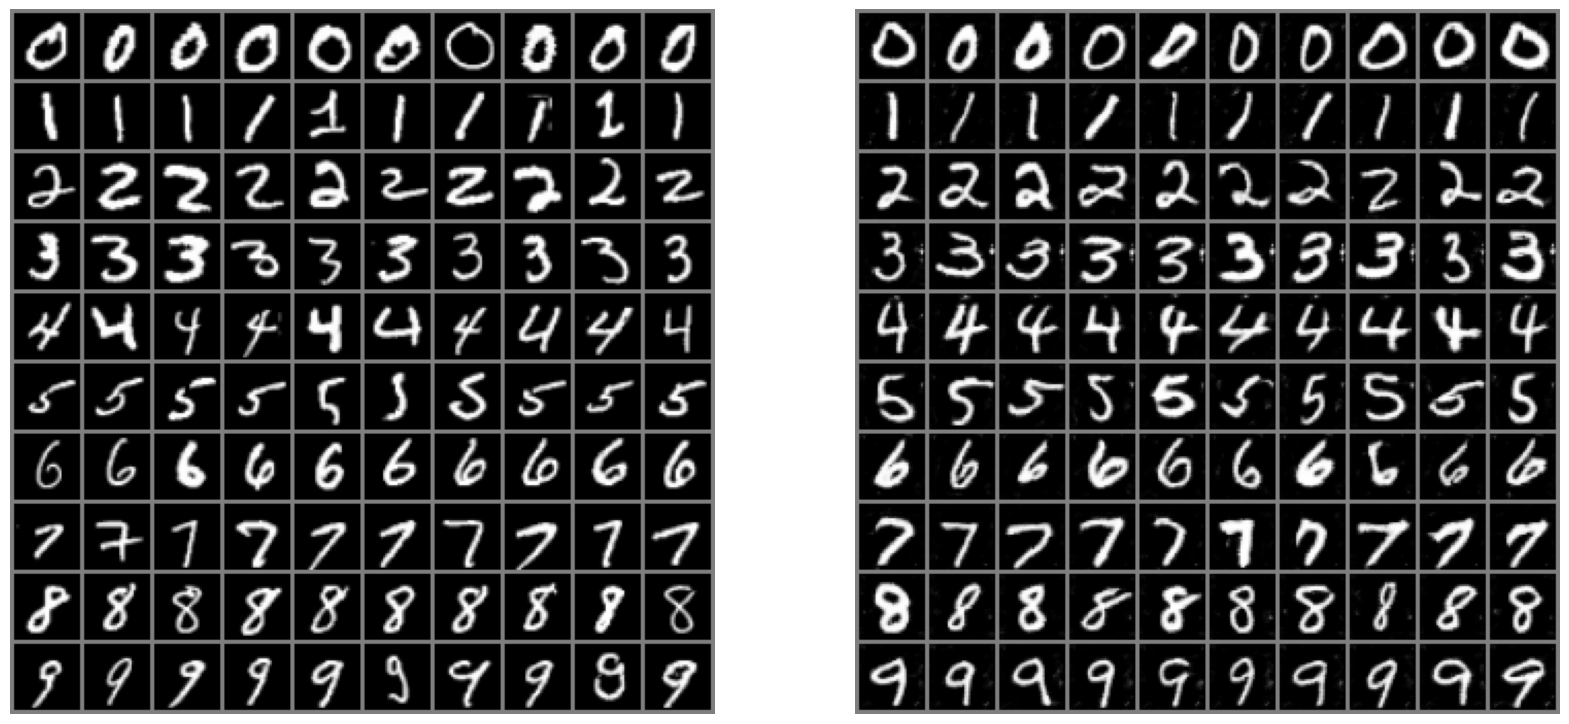

In [96]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.axis('off')
plt.title("")
imgs = utils.make_grid(imgs, nrow=10)
plt.imshow(imgs.permute(1, 2, 0)*0.5+0.5)

netG = Generator(1)
netG.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
netG.eval()

with torch.no_grad():
    fake = netG(fixed_noise.cpu(), fixed_label.cpu())

plt.subplot(1,2,2)
plt.axis("off")
plt.title("")
fake = utils.make_grid(fake, nrow=10)
plt.imshow(fake.permute(1, 2, 0)*0.5+0.5)

plt.savefig('result.jpg', bbox_inches='tight')